In [ ]:
import warnings
warnings.filterwarnings("ignore")


In [ ]:
pip install transformers datasets torch scikit-learn numpy pandas evaluate tqdm matplotlib seaborn nltk spacy



In [38]:
!pip uninstall -y keras
!pip uninstall -y tensorflow tensorflow-cpu tensorflow-gpu
!pip uninstall -y tf_keras

import os
os.environ["TRANSFORMERS_NO_TF"] = "1"


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Found existing installation: keras 3.9.2
Uninstalling keras-3.9.2:
  Successfully uninstalled keras-3.9.2


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Found existing installation: tensorflow 2.16.2
Uninstalling tensorflow-2.16.2:
  Successfully uninstalled tensorflow-2.16.2


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


## 1. Load data + merge abstract

In [13]:
from datasets import load_dataset
import pandas as pd

dataset = load_dataset("pietrolesci/pubmed-20k-rct")

def build_abstracts(split):
    ds = dataset[split]
    df = pd.DataFrame({
        "abstract_id": ds["abstract_id"],
        "text": ds["text"]
    })

    # Merge all sentences for each abstract_id
    abstract_df = (
        df.groupby("abstract_id")["text"]
          .apply(lambda sentences: " ".join(sentences))
          .reset_index()
          .rename(columns={"text": "abstract"})
    )

    return abstract_df

# Generate abstract-level dataframes
train_abs = build_abstracts("train")
valid_abs = build_abstracts("validation")
test_abs  = build_abstracts("test")

print(train_abs.head())
print(valid_abs.head())
print(test_abs.head())

print("Train abstracts:", len(train_abs))
print("Validation abstracts:", len(valid_abs))
print("Test abstracts:", len(test_abs))


  abstract_id                                           abstract
0    24219770  The purpose of this study was to determine the...
1    24219814  Repeated courses of intravenous ( IV ) aminogl...
2    24219842  To determine whether the Pediatric Asthma Cont...
3    24219852  Despite the benefits of endoscopic nasobiliary...
4    24219882  We assessed the impact of hot flashes and vari...
  abstract_id                                           abstract
0    24219891  High intake of added sweeteners is considered ...
1    24220044  To evaluate the effects of training in methods...
2    24220504  Osteoarthritis is a relatively common musculos...
3    24220704  To develop an optimal model and age-specific c...
4    24220935  We investigated potential biomarkers of effica...
  abstract_id                                           abstract
0    24220007  Although the potential benefits of @-dimension...
1    24220099  Increasing levels of physical activity in moth...
2    24220161  Prenatal s

Matplotlib is building the font cache; this may take a moment.


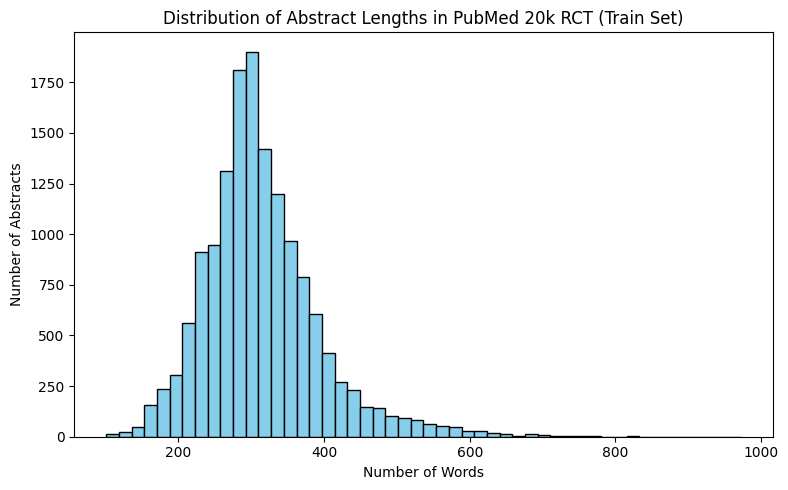

In [10]:
import matplotlib.pyplot as plt

lengths = train_abs["abstract"].apply(lambda x: len(x.split()))

plt.figure(figsize=(8,5))
plt.hist(lengths, bins=50, color='skyblue', edgecolor='black')
plt.title("Distribution of Abstract Lengths in PubMed 20k RCT (Train Set)")
plt.xlabel("Number of Words")
plt.ylabel("Number of Abstracts")
plt.tight_layout()
plt.show()


## 2. Labeling

In [14]:
def label_topic(text):
    t = text.lower()

    # Diabetes keywords
    diabetes_kw = [
        "diabetes", "insulin", "hyperglycemia", "hba1c",
        "glucose intolerance", "glucose control", "type 2 diabetes", "type ii diabetes"
    ]

    # Cancer keywords
    cancer_kw = [
        "cancer", "carcinoma", "tumor", "tumour", "oncology",
        "neoplasm", "chemotherapy", "metastatic", "breast cancer", "lung cancer"
    ]

    # Labeling logic
    if any(k in t for k in diabetes_kw):
        return "diabetes"
    elif any(k in t for k in cancer_kw):
        return "cancer"
    else:
        return "other"


# Apply labeling to each split
for df in [train_abs, valid_abs, test_abs]:
    df["label_str"] = df["abstract"].astype(str).apply(label_topic)

# Convert to numeric ids
label2id = {"diabetes": 0, "cancer": 1, "other": 2}
for df in [train_abs, valid_abs, test_abs]:
    df["label"] = df["label_str"].map(label2id)

print(train_abs.head())
print(train_abs["label_str"].value_counts())


  abstract_id                                           abstract label_str  \
0    24219770  The purpose of this study was to determine the...     other   
1    24219814  Repeated courses of intravenous ( IV ) aminogl...     other   
2    24219842  To determine whether the Pediatric Asthma Cont...     other   
3    24219852  Despite the benefits of endoscopic nasobiliary...     other   
4    24219882  We assessed the impact of hot flashes and vari...     other   

   label  
0      2  
1      2  
2      2  
3      2  
4      2  
label_str
other       12160
cancer       1705
diabetes     1135
Name: count, dtype: int64


## 3. Baseline: linear SVM + TF-IDF

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score, f1_score
import pandas as pd

# Extract train/val/test splits
X_train = train_abs["abstract"].astype(str).tolist()
y_train = train_abs["label"].tolist()

X_valid = valid_abs["abstract"].astype(str).tolist()
y_valid = valid_abs["label"].tolist()

X_test = test_abs["abstract"].astype(str).tolist()
y_test = test_abs["label"].tolist()


# Build TF-IDF features

vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),       # unigrams + bigrams
    max_features=60000,       # large enough for biomedical text
    sublinear_tf=True         # improves SVM performance
)

# Fit on training data
X_train_tfidf = vectorizer.fit_transform(X_train)

# Transform validation / test
X_valid_tfidf = vectorizer.transform(X_valid)
X_test_tfidf  = vectorizer.transform(X_test)


# Train Linear SVM

svm = LinearSVC()
svm.fit(X_train_tfidf, y_train)


# Evaluate on test set

y_pred = svm.predict(X_test_tfidf)

test_accuracy = accuracy_score(y_test, y_pred)
test_macro_f1 = f1_score(y_test, y_pred, average="macro")

print("===== TF-IDF + Linear SVM Baseline =====")
print("Test Accuracy :", test_accuracy)
print("Macro F1      :", test_macro_f1)
print("\nClassification Report:")
print(classification_report(
    y_test, y_pred,
    target_names=["diabetes", "cancer", "other"]
))

# Save results for model comparison later
svm_results = {
    "model": "TF-IDF + Linear SVM",
    "accuracy": test_accuracy,
    "macro_f1": test_macro_f1
}


/Users/mayyy/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


===== TF-IDF + Linear SVM Baseline =====
Test Accuracy : 0.9612
Macro F1      : 0.9118145905100294

Classification Report:
              precision    recall  f1-score   support

    diabetes       0.99      0.74      0.85       200
      cancer       0.94      0.87      0.91       297
       other       0.96      1.00      0.98      2003

    accuracy                           0.96      2500
   macro avg       0.97      0.87      0.91      2500
weighted avg       0.96      0.96      0.96      2500



## 4. BERT 

### 4.1 HugingFace dataset

In [17]:
from datasets import Dataset, DatasetDict

def df_to_hf(df):
    return Dataset.from_pandas(df[["abstract", "label"]])

hf_train = df_to_hf(train_abs)
hf_valid = df_to_hf(valid_abs)
hf_test  = df_to_hf(test_abs)

dataset_dict = DatasetDict({
    "train": hf_train,
    "valid": hf_valid,
    "test": hf_test
})


### 4.2 Tokenize

In [19]:
from transformers import AutoTokenizer

model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_fn(batch):
    return tokenizer(
        batch["abstract"],
        truncation=True,
        padding="max_length",
        max_length=256
    )

tokenized = dataset_dict.map(tokenize_fn, batched=True)
tokenized = tokenized.remove_columns(["abstract"])
tokenized.set_format("torch")


/Users/mayyy/anaconda3/envs/bioenv/lib/python3.10/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Map: 100%|█████████████████████████| 2500/2500 [00:01<00:00, 1810.13 examples/s]


### 4.3 BERT

In [12]:
from transformers import AutoModelForSequenceClassification

num_labels = 3  # diabetes / cancer / other

bert_model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels
)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 4.4 Accuracy + Macro-F1

In [14]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average="macro")
    return {"accuracy": acc, "macro_f1": f1}


### 4.5 Training Bert 

In [19]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="./bert-base-uncased-output",
    do_train=True,
    do_eval=True,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_steps=100,
    save_steps=1000
)

trainer_bert = Trainer(
    model=bert_model,
    args=training_args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["valid"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer_bert.train()


/var/folders/jd/9jldz3_d1ng5prz_xhlmh5ww0000gn/T/ipykernel_21209/720811774.py:16: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_bert = Trainer(


Step,Training Loss
100,0.097100
200,0.116000
300,0.093500
400,0.084400
500,0.084300
600,0.073000
700,0.141000
800,0.110300
900,0.066900
1000,0.125400


/Users/mayyy/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:255: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  arr = np.array(obj)
/Users/mayyy/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:255: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modi

{'eval_loss': 0.08648926764726639, 'eval_accuracy': 0.9848, 'eval_macro_f1': 0.9668737698447106, 'eval_runtime': 498.621, 'eval_samples_per_second': 5.014, 'eval_steps_per_second': 0.315, 'epoch': 2.0}


## 4.6 Performance

In [3]:

bert_results = trainer_bert.evaluate(tokenized["test"])
print(bert_results)

bert_base_metrics = {
    "model": "bert-base-uncased",
    "accuracy": bert_results["eval_accuracy"],
    "macro_f1": bert_results["eval_macro_f1"]
}


NameError: name 'trainer_bert' is not defined

## BioBERT

In [1]:
pip install transformers datasets accelerate


  Using cached dill-0.4.0-py3-none-any.whl.metadata (10 kB)
Using cached dill-0.4.0-py3-none-any.whl (119 kB)
  Attempting uninstall: dill
    Found existing installation: dill 0.3.8
    Uninstalling dill-0.3.8:
ERROR: Could not install packages due to an OSError: Cannot move the non-empty directory '/Users/mayyy/anaconda3/lib/python3.11/site-packages/dill-0.3.8.dist-info/': Lacking write permission to '/Users/mayyy/anaconda3/lib/python3.11/site-packages/dill-0.3.8.dist-info/'.

Note: you may need to restart the kernel to use updated packages.


## 5.1 import BioBERT

In [21]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

checkpoint = "dmis-lab/biobert-base-cased-v1.1"

tokenizer = AutoTokenizer.from_pretrained(checkpoint)

model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint,
    num_labels=3   # three classes: diabetes, cancer, other
)


/Users/mayyy/anaconda3/envs/bioenv/lib/python3.10/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/Users/mayyy/anaconda3/envs/bioenv/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it 

## 5.2 Tokenization

In [24]:
def tokenize_function(examples):
    return tokenizer(
        examples["abstract"],
        truncation=True,
        padding="max_length",
        max_length=128  
    )


## 5.3 HF dataset

In [27]:
from datasets import Dataset

train_dataset = Dataset.from_pandas(train_abs)
valid_dataset = Dataset.from_pandas(valid_abs)
test_dataset  = Dataset.from_pandas(test_abs)

train_dataset = train_dataset.map(tokenize_function, batched=True)
valid_dataset = valid_dataset.map(tokenize_function, batched=True)
test_dataset  = test_dataset.map(tokenize_function, batched=True)

train_dataset = train_dataset.remove_columns(["abstract"])
valid_dataset = valid_dataset.remove_columns(["abstract"])
test_dataset  = test_dataset.remove_columns(["abstract"])

train_dataset = train_dataset.with_format("torch")
valid_dataset = valid_dataset.with_format("torch")
test_dataset  = test_dataset.with_format("torch")


Map: 100%|█████████████████████████| 2500/2500 [00:01<00:00, 2190.96 examples/s]


## 5.4 TrainingArguments

In [30]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="biobert-results",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    learning_rate=3e-5,
    num_train_epochs=2,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    warmup_steps=200,
    weight_decay=0.01,
    logging_steps=100,
    load_best_model_at_end=True,
    report_to="none"
)


## 5.5 Metrics (macro-F1)

In [33]:
import evaluate
import numpy as np

accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy.compute(predictions=preds, references=labels)["accuracy"],
        "macro_f1": f1.compute(predictions=preds, references=labels, average="macro")["f1"]
    }


## 5.6 Train

In [35]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)
trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,0.282700,0.180798,0.966800,0.929836
2,0.145000,0.167818,0.967200,0.932040


TrainOutput(global_step=7500, training_loss=0.19761837069193522, metrics={'train_runtime': 24545.5069, 'train_samples_per_second': 1.222, 'train_steps_per_second': 0.306, 'total_flos': 1973350632960000.0, 'train_loss': 0.19761837069193522, 'epoch': 2.0})

## 5.7 Evaluate

In [38]:
results = trainer.evaluate(test_dataset)
results


{'eval_loss': 0.2096550017595291,
 'eval_accuracy': 0.9604,
 'eval_macro_f1': 0.9129709166941256,
 'eval_runtime': 319.7608,
 'eval_samples_per_second': 7.818,
 'eval_steps_per_second': 1.955,
 'epoch': 2.0}